In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Fashion - MNIST - https://github.com/zalandoresearch/fashion-mnist
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
train_images_norm = x_train / 255.0
test_images_norm = x_test / 255.0


In [217]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

# Define the model
model = Sequential()

model.add(Conv2D(filters=75, kernel_size=4,  activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=83, kernel_size=2, activation='relu')) 
#model.add(MaxPooling2D(pool_size=2))
#model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(72, activation='relu'))
model.add(Dense(10))
# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 25, 25, 75)        1275      
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 12, 12, 75)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 11, 11, 83)        24983     
_________________________________________________________________
flatten_96 (Flatten)         (None, 10043)             0         
_________________________________________________________________
dense_192 (Dense)            (None, 72)                723168    
_________________________________________________________________
dense_193 (Dense)            (None, 10)                730       
Total params: 750,156
Trainable params: 750,156
Non-trainable params: 0
_______________________________________________

In [218]:
model.fit(train_images_norm, y_train, epochs=1, validation_split=0.1)

1688/1688 [==============================] - 19s 11ms/step - loss: 0.5595 - accuracy: 0.7963 - val_loss: 0.3029 - val_accuracy: 0.8875


In [219]:
MODELS_DIR = '/home/wigand/projects/ml/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [220]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: /home/wigand/projects/ml/models/model/assets


In [221]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([train_images_norm.astype(np.float32)[i].reshape(1, 28, 28, 1)])

In [222]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

758192

In [44]:
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

280688

In [20]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((10000, 28, 28, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(shape= (10000, 10), dtype=output_details["dtype"])
    print(input_details['dtype'])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        inter = interpreter.get_tensor(output_details["index"])
        y_pred[i] = np.array(inter[0], dtype="float32")

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss

In [21]:
y_test_pred_tf = model.predict(test_images_norm)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, test_images_norm)
y_test_pred_tflite = predict_tflite(model_tflite, np.array(test_images_norm, dtype="int8"))

<class 'numpy.float32'>
<class 'numpy.int8'>


In [22]:
y_last = np.empty(10000, dtype="int8")
for g in range(y_test_pred_no_quant_tflite.shape[0]):
    y_last[g] = np.argmax(y_test_pred_no_quant_tflite[g])

In [23]:
y_last_quant = np.empty(10000, dtype="int8")
for g in range(y_test_pred_tflite.shape[0]):
    y_last_quant[g] = np.argmax(y_test_pred_tflite[g])

In [24]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_last, y_test))
print(accuracy_score(y_last_quant, y_test))

0.8713
0.1182


In [25]:
import pandas as pd
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [223]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,230576 bytes,(reduced by -226480 bytes)
TensorFlow Lite Quantized,230296 bytes,(reduced by 280 bytes)


In [224]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!sed -i 's/unsigned char/#include "model.h"\nalignas(8) const unsigned char/' {MODEL_TFLITE_MICRO}
!sed -i 's/unsigned int g_model_len/const int g_model_len/' {MODEL_TFLITE_MICRO}

Paketlisten werden gelesen... Fertig
E: Sperrdatei /var/lib/apt/lists/lock konnte nicht geöffnet werden. - open (13: Keine Berechtigung)
E: Das Verzeichnis /var/lib/apt/lists/ kann nicht gesperrt werden.
W: Problem beim Entfernen (unlink) der Datei /var/cache/apt/pkgcache.bin - RemoveCaches (13: Keine Berechtigung)
W: Problem beim Entfernen (unlink) der Datei /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Keine Berechtigung)


In [225]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

#include "model.h"
alignas(8) const unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00,
  0xdc, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00,
  0x7c, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00, 0x18, 0x08, 0x00, 0x00,
  0xf8, 0x06, 0x00, 0x00, 0xf4, 0x05, 0x00, 0x00, 0xec, 0x03, 0x00, 0x00,
  0xf0, 0x02, 0x00, 0x00, 0x9c, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xd0, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x44, 0x91, 0x0b, 0x00,
  0x40, 0x91, 0x0b, 0x00, 0x4c, 0x90, 0x0b, 0x00, 0x8c, 0x87, 0x0b, 0x00,
  0x40, 0x82, 0x0b, 0x00, 0xa4, 0x1c, 0x0b, 0x00, 0xd8, 0x16, 0x0b, 0x00,
  0xc8, 0x0d, 0x00, 0x00, 0x40, 0x0c, 0x00, 0x00, 0xf8, 0x08, 0x00, 0x00,
  0x68, 0x08, 0x00, 0x00, 0x18, 0x91, 0x0b, 0x00

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [226]:
import os
import shutil
os.rename(MODEL_TFLITE_MICRO, 'model.cpp')
shutil.move("/home/wigand/projects/ml/model.cpp", "/home/wigand/Arduino/Modell_V1/model.cpp")

'/home/wigand/Arduino/Modell_V1/model.cpp'

In [227]:
y_test_pred_no_quant_tflite[1878]

array([  0.9489424 ,  -2.7282095 ,   7.5915394 ,  -0.11861777,
         5.693654  ,  -3.0840628 ,   7.1170683 ,  -3.2026808 ,
         1.7792671 , -10.556985  ], dtype=float32)

In [228]:
test_images_norm[1878].flatten()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25882353,
       0.72156863, 0.65882353, 0.79215686, 0.69019608, 0.65490196,
       0.72156863, 0.71764706, 0.75294118, 0.67843137, 0.20392157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00392157, 0.        , 0.02745098,
       0.61960784, 1.        , 0.58039216, 0.97647059, 0.41568627,
       0.11372549, 0.28627451, 0.48627451, 0.38039216, 0.56470588,
       0.81960784, 0.91764706, 0.6627451 , 1.        , 0.64313725,
       0.12156863, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.61568627, 0.88627451, 0.80784314,
       0.66666667, 0.74901961, 1.        , 0.49411765, 0.74117647,
       0.95294118, 0.5372549 , 0.87058824, 1.        , 0.54509

In [53]:
loss_tf, _ = model.evaluate(test_images_norm, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, test_images_norm, y_test)
loss_tflite = evaluate_tflite(model_tflite, test_images_norm, y_test)


# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

<class 'numpy.float32'>
<class 'numpy.int8'>


,Loss/MSE
Model,
TensorFlow,0.4748
TensorFlow Lite,0.4758
TensorFlow Lite Quantized,0.4756


In [51]:
# Fashion - MNIST - https://github.com/zalandoresearch/fashion-mnist
fashion_mnist = keras.datasets.fashion_mnist

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

In [52]:
x_train_raw = x_train.reshape((60000, 28, 28, 1))
x_test_raw = x_test.reshape((10000, 28, 28, 1))
train_images_norm_raw = x_train_raw / 255.0
test_images_norm_raw = x_test_raw / 255.0

In [53]:
compare_x = train_images_norm_raw[1].copy()
pad_width = 10
new_shape = pad_width*2+28
train_images_norm_raw = train_images_norm_raw.reshape(60000, 28, 28)
train_images_norm_raw_scaled = np.zeros((60000, new_shape, new_shape))
for i in range(len(train_images_norm_raw)):
    train_images_norm_raw_scaled[i] = np.pad(train_images_norm_raw[i], pad_width=pad_width, mode='constant', constant_values=0)
train_images_norm_raw = train_images_norm_raw_scaled.reshape(60000, new_shape, new_shape, 1)

compare_y = train_images_norm_raw[1].copy()

6272


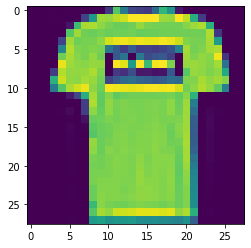

In [58]:
plt.figure()
plt.imshow(np.squeeze(compare_x))
print(compare_x.nbytes)

18432


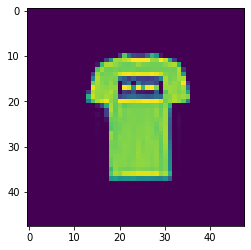

In [59]:
plt.figure()
plt.imshow(np.squeeze(compare_y))
print(compare_y.nbytes)

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

# Define the model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, activation='relu', input_shape=(new_shape,new_shape,1))) 
model.add(Conv2D(filters=9, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(35, activation='relu'))
model.add(Dense(10))
# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 45, 45, 16)        272       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 9)         585       
_________________________________________________________________
flatten_5 (Flatten)          (None, 17424)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 35)                609875    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                360       
Total params: 611,092
Trainable params: 611,092
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_images_norm, y_train, epochs=1, validation_split=0.1)

In [ ]:
MODELS_DIR = '/home/wigand/projects/ml/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [229]:
inferenzV1 = [55.327,
31.275,
26.870,
48.401,
94.813,
115.545,
135.898,
172.981,
151.824,
153.523,
157.349,
99.980,
126.398,
153.037,
192.675,
205.324,
198.031,
172.951,
231.011,
258.080,
168.539,
191.983,
220.443,
256.213,
267.219,
243.987,
343.943,
408.681,
444.108,
280.921]
inferenz = np.array(inferenzV1)

In [230]:
computational = [254.694,
88.402,
59.546,
238.702,
695.130,
947.450,
1189.770,
1555.074,
1355.734,
1393.352,
1454.853,
852.540,
1141.672,
1430.804,
1872.508,
2012.562,
1971.936,
1702.252,
2303.114,
2585.918,
1644.938,
1948.874,
2229.742,
2657.198,
2803.146,
2610.101,
3796.460,
4486.798,
4952.412,
3103.705]

In [231]:
modelsize= [3.007,
5.085,
10.019,
25.031,
50.064,
75.070,
100.059,
125.147,
150.056,
175.004,
200.027,
225.151,
250.099,
275.047,
300.125,
325.175,
350.020,
375.240,
400.116,
425.168,
450.019,
475.180,
500.216,
550.115,
600.067,
650.281,
700.028,
750.156,
800.195,
840.154]

In [232]:
ArrayByteV1=[6.728,
8.384,
13.864,
29.312,
55.120,
80.512,
105.848,
131.176,
155.912,
180.936,
206.032,
230.576,
255.792,
280.968,
306.464,
331.592,
356.416,
381.432,
406.752,
431.984,
456.176,
481.576,
506.856,
557.032,
607.112,
657.192,
707.704,
758.192,
808.504,
847.464]

In [233]:
SketchV1=[140.216,
141.952,
147.432,
162.880,
188.688,
214.080,
239.416,
264.744,
289.480,
314.504,
339.600,
364.144,
389.360,
414.536,
440.032,
465.160,
489.984,
515.000,
540.320,
565.552,
589.744,
615.144,
640.424,
690.600,
740.680,
790.760,
841.272,
891.760,
942.072,
981.032]

In [234]:
MaxLayerSize = [14.375,
4.375,
2.500,
8.750,
18.750,
20.000,
20.625,
30.625,
25.000,
23.750,
23.750,
11.875,
16.875,
21.875,
28.125,
29.375,
27.500,
22.500,
35.000,
38.125,
20.000,
23.750,
26.875,
31.250,
31.250,
27.500,
40.000,
46.875,
50.625,
28.125]

In [235]:
TensorArenaSizeV1 = [18.972,
6.540,
5.196,
12.172,
24.700,
26.332,
27.244,
39.612,
32.620,
31.116,
31.116,
16.348,
22.556,
28.780,
36.588,
38.156,
35.820,
29.612,
45.116,
49.052,
26.524,
31.212,
35.116,
40.604,
40.636,
35.948,
51.548,
60.140,
64.860,
36.844]

In [236]:
inf_compV1=[0.217230852,
0.353784863,
0.451240704,
0.202766751,
0.13639554,
0.121953568,
0.11422243,
0.111236651,
0.111986608,
0.110182769,
0.108154389,
0.117273553,
0.110713221,
0.106958441,
0.102896813,
0.102021054,
0.100424499,
0.101601236,
0.100303574,
0.099802153,
0.102459189,
0.098509744,
0.09886466,
0.096422167,
0.095328366,
0.09347782,
0.090595741,
0.091085306,
0.089675179,
0.090511527]

In [237]:
ArrayByteV2 = [14.420,
22.796,
42.908,
102.956,
203.088,
303.120,
403.092,
503.444,
603.080,
702.872,
802.988]

In [238]:
SketchV2=[147.992,
156.368,
176.480,
236.528,
336.656,
436.688,
536.664,
637.016,
736.648,
836.440,
936.560]

In [239]:
TensorArenaSizeV2 = [71.844,
22.500,
14.228,
44.292,
93.732,
99.972,
103.188,
152.468,
124.708,
118.596,
118.596]

In [240]:
inferenzV2=[317.521,
103.648,
63.476,
242.252,
640.209,
811.645,
971.066,
1298.196,
1098.516,
1101.571,
1131.043]

In [241]:
inf_compV2=[1.246678005,
1.172460971,
1.066005804,
1.014872761,
0.920991814,
0.856662968,
0.816179421,
0.834813209,
0.810273798,
0.790590557,
0.777427595]

In [242]:
titles = {'fontsize': 13}

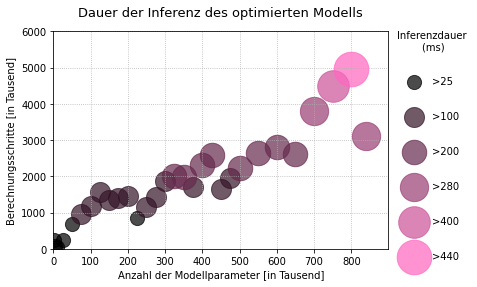

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
N = 50
M = 6 # Number of bins
 

a2 = inferenzV1
x = modelsize[:len(a2)]
y = computational[:len(a2)]
 
# Create the DataFrame from your randomised data and bin it using groupby.
df = pd.DataFrame(data=dict(x=x, y=y, a2=a2))
bins = np.linspace(df.a2.min(), df.a2.max(), M)
grouped = df.groupby(np.digitize(df.a2, bins))
 
# Create some sizes and some labels.
sizes = [200*(i+1.) for i in range(M)]
labels = ['>25', '>100', '>200', '>280', '>400', '>440']
 
for i, (name, group) in enumerate(grouped):
    #print(group.a2)
    #c=[[0.25*i, 0.08*i, 0.15*i]])
    plt.scatter(group.x, group.y, s=sizes[i], alpha=0.7, label=labels[i], c=[[0.20*i, 0.08*i, 0.15*i]])
plt.xlim(0, 899)
plt.ylim(0, 6000)
plt.grid(True,linestyle='dotted')
plt.title('Dauer der Inferenz des optimierten Modells', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Berechnungsschritte [in Tausend]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.475), title="Inferenzdauer\n        (ms)",
           labelspacing =2.5, frameon=False)
plt.show()

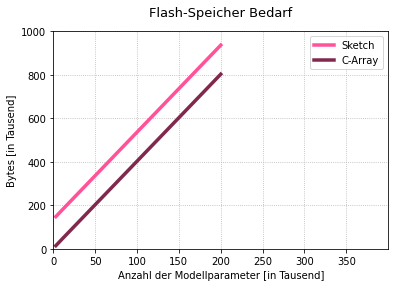

In [244]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
sketch = SketchV2
arraybyte = ArrayByteV2

# plot lines
plt.plot(modelsize[:len(sketch)], sketch, label = "Sketch", linestyle="-", c=[1, 0.32, 0.6], linewidth=3.5)
plt.plot(modelsize[:len(arraybyte)], arraybyte, label = "C-Array", linestyle="-", c=[0.5, 0.16, 0.3], linewidth=3.5)
#plt.plot(modelsize, modelsize, label = "Anzahl der Parameter", linestyle=":", c=[1, 0.48, 0.45], linewidth=3.5)
#plt.plot(x, np.cos(x), label = "curve 2", linestyle=":")
plt.xlim(0, 400)
plt.ylim(0, 1000)
plt.xticks(np.arange(0, 400, 50))
plt.yticks(np.arange(0, 1200, 200))
plt.title('Flash-Speicher Bedarf', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Bytes [in Tausend]")
plt.grid(True,linestyle='dotted')
plt.legend()
plt.show()

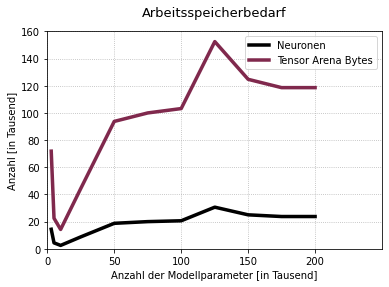

In [245]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
tensorarena = TensorArenaSizeV2

# plot lines
plt.plot(modelsize[:len(tensorarena)], MaxLayerSize[:len(tensorarena)], label = "Neuronen", linestyle="-", c="black", linewidth=3.5)
plt.plot(modelsize[:len(tensorarena)], tensorarena, label = "Tensor Arena Bytes", linestyle="-", c=[0.5, 0.16, 0.3], linewidth=3.5)
#plt.plot(modelsize, modelsize, label = "Anzahl der Parameter", linestyle=":", c=[1, 0.48, 0.45], linewidth=3.5)
#plt.plot(x, np.cos(x), label = "curve 2", linestyle=":")
plt.xlim(0, 250)
plt.ylim(0, 70)
plt.xticks(np.arange(0, 250, 50))
plt.yticks(np.arange(0, 180,20))
plt.title('Arbeitsspeicherbedarf', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Anzahl [in Tausend]")
plt.grid(True,linestyle='dotted')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


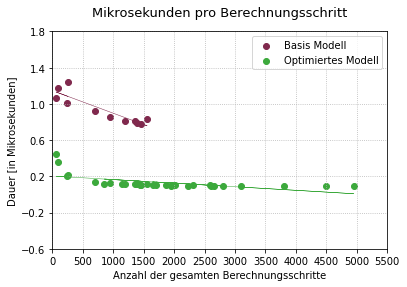

In [246]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
#inf_compV1 = inf_compV1
inf_compV2 = inf_compV2

# plot lines
#plt.plot(inf_compV1, label = "V1", linestyle="-", c=[1, 0.32, 0.6], linewidth=3.5)
plt.scatter(computational[:len(inf_compV2)], inf_compV2,  label = "Basis Modell", linestyle="-", c=[0.5, 0.16, 0.3], linewidth=1)
plt.scatter(computational[:len(inf_compV1)], inf_compV1,  label = "Optimiertes Modell", linestyle="-", c="#3CA93C", linewidth=1)
#plt.plot(x, np.cos(x), label = "curve 2", linestyle=":")
z = np.polyfit(computational[:len(inf_compV2)], inf_compV2, 1)
p = np.poly1d(z)
plt.plot(computational[:len(inf_compV2)],p(computational[:len(inf_compV2)]),"-", c=[0.5, 0.16, 0.3], lw = 0.5)

t = np.polyfit(computational[:len(inf_compV1)], inf_compV1, 1)
h = np.poly1d(t)
plt.plot(computational[:len(inf_compV1)],h(computational[:len(inf_compV1)]),"-", c="#3CA93C", lw = 0.5)

plt.xlim(0, 5501)
plt.ylim(-0.6, 1.801)
plt.xticks(np.arange(0, 5501, 500))
plt.yticks(np.arange(-0.6, 1.801, 0.4))
#plt.plot([0,5500],[0,0],lw=0.5, c="black")
plt.title('Mikrosekunden pro Berechnungsschritt', pad=15, fontdict = titles)
plt.xlabel("Anzahl der gesamten Berechnungsschritte")
plt.ylabel("Dauer [in Mikrosekunden]")
plt.grid(True,linestyle='dotted')
plt.legend()
plt.show()

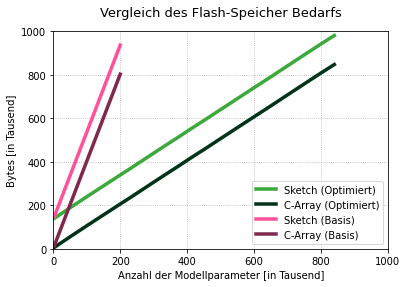

In [247]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
sketch1 = SketchV1
arraybyte1 = ArrayByteV1
sketch2 = SketchV2
arraybyte2 = ArrayByteV2

# plot lines
plt.plot(modelsize[:len(sketch1)], sketch1, label = "Sketch (Optimiert)", linestyle="-", c="#3CA93C", linewidth=3.5)
plt.plot(modelsize[:len(arraybyte1)], arraybyte1, label = "C-Array (Optimiert)", linestyle="-", c="#003319", linewidth=3.5)
plt.plot(modelsize[:len(sketch2)], sketch2, label = "Sketch (Basis)", linestyle="-", c=[1, 0.32, 0.6], linewidth=3.5)
plt.plot(modelsize[:len(arraybyte2)], arraybyte2, label = "C-Array (Basis)", linestyle="-", c=[0.5, 0.16, 0.3], linewidth=3.5)
#plt.plot(modelsize, modelsize, label = "Anzahl der Parameter", linestyle=":", c=[1, 0.48, 0.45], linewidth=3.5)
#plt.plot(x, np.cos(x), label = "curve 2", linestyle=":")
plt.xlim(0, 1001)
plt.ylim(0, 1000)
plt.xticks(np.arange(0, 1001, 200))
plt.yticks(np.arange(0, 1200, 200))
plt.title('Vergleich des Flash-Speicher Bedarfs', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Bytes [in Tausend]")
plt.grid(True,linestyle='dotted')
plt.legend()
plt.show()

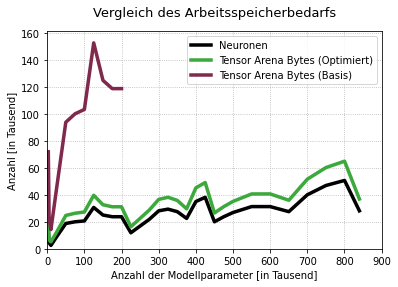

In [248]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
tensorarena = TensorArenaSizeV1
tensorarena2 = TensorArenaSizeV2

# plot lines
plt.plot(modelsize[:len(tensorarena)], MaxLayerSize[:len(tensorarena)], label = "Neuronen", linestyle="-", c="black", linewidth=3.5)
plt.plot(modelsize[:len(tensorarena)], tensorarena, label = "Tensor Arena Bytes (Optimiert)", linestyle="-", c="#3CA93C", linewidth=3.5)
plt.plot(modelsize[:len(tensorarena2)], tensorarena2, label = "Tensor Arena Bytes (Basis)", linestyle="-", c=[0.5, 0.16, 0.3], linewidth=3.5)
#plt.plot(x, np.cos(x), label = "curve 2", linestyle=":")
plt.xlim(0, 901)
plt.ylim(0, 161)
plt.xticks(np.arange(0, 901, 100))
plt.yticks(np.arange(0, 161, 20))
plt.title('Vergleich des Arbeitsspeicherbedarfs', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Anzahl [in Tausend]")
plt.grid(True,linestyle='dotted')
plt.legend()
plt.show()

In [625]:
an_array = np.array(inferenz)
scale = (np.amax(an_array) - np.amin(an_array))/1000

inf_scale = np.zeros(18)
for i in range(len(inferenz)):
    inf_scale[i] = inferenz[i]/scale
inf_scale

array([  74.98837594,  132.392064  ,   64.39969514,  116.00333623,
        227.23960905,  227.23960905,  276.92827595,  325.70858838,
        414.58591979,  363.8786496 ,  367.95066605,  377.12049238,
        461.78679794,  553.66721152,  528.33874192,  640.4474185 ,
        824.33287476, 1064.39969514])

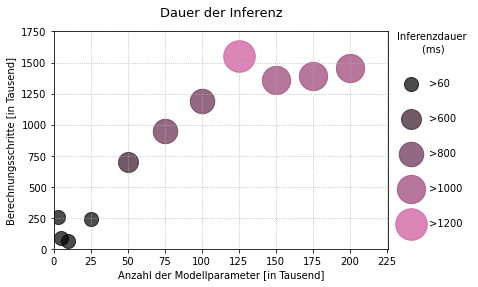

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
N = 50
M = 5 # Number of bins
 

a2 = inferenzV2
x = modelsize[:len(a2)]
y = computational[:len(a2)]
 
# Create the DataFrame from your randomised data and bin it using groupby.
df = pd.DataFrame(data=dict(x=x, y=y, a2=a2))
bins = np.linspace(df.a2.min(), df.a2.max(), M)
grouped = df.groupby(np.digitize(df.a2, bins))
 
# Create some sizes and some labels.
sizes = [200*(i+1.) for i in range(M)]
labels = ['>60', '>600', '>800', '>1000', '>1200']
 
for i, (name, group) in enumerate(grouped):
    #print(group.a2)
    plt.scatter(group.x, group.y, s=sizes[i], alpha=0.7, label=labels[i], c=[[0.20*i, 0.08*i, 0.15*i]])
plt.xlim(0, 226)
plt.ylim(0, 1751)
plt.xticks(np.arange(0, 226, 25))
plt.yticks(np.arange(0, 1751, 250))
plt.grid(True,linestyle='dotted')
plt.title('Dauer der Inferenz', pad=15, fontdict = titles)
plt.xlabel("Anzahl der Modellparameter [in Tausend]")
plt.ylabel("Berechnungsschritte [in Tausend]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.547), title="Inferenzdauer\n        (ms)",
           labelspacing =2.5, frameon=False)
plt.show()